loading data
data shapes: (100, 7) (100, 7) (100, 1) (100, 1)
plotting data


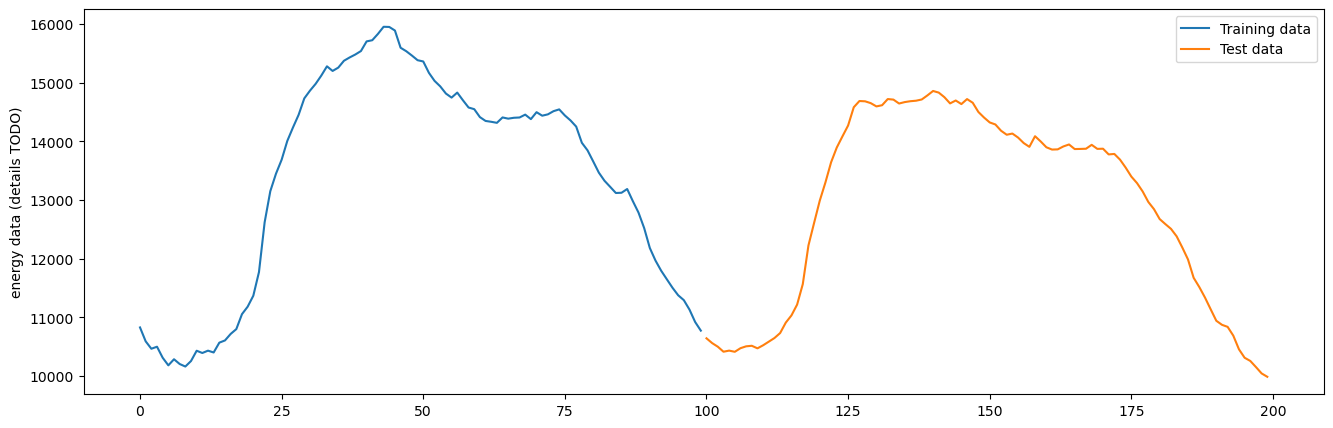

running native methods
running native methods
estimating QR intervals
training base model
running posthoc methods
estimating CP intervals
loaded model successfully
predicting...
plotting native vs posthoc results
plotting native results...


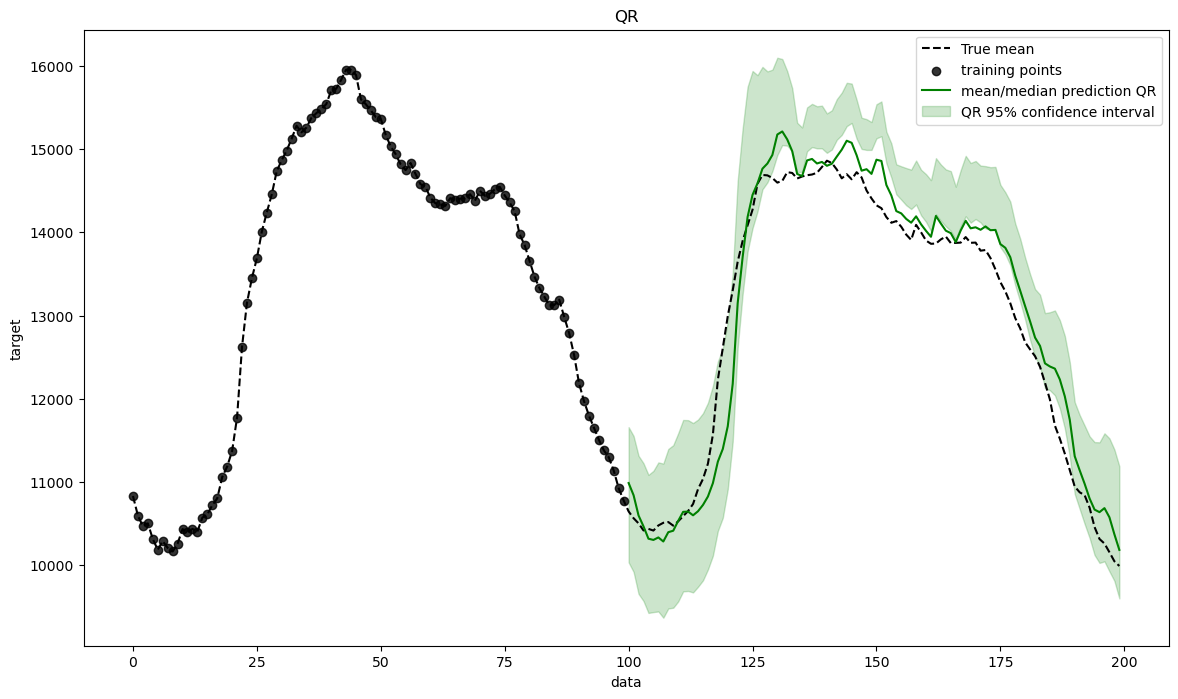

plotting posthoc results...


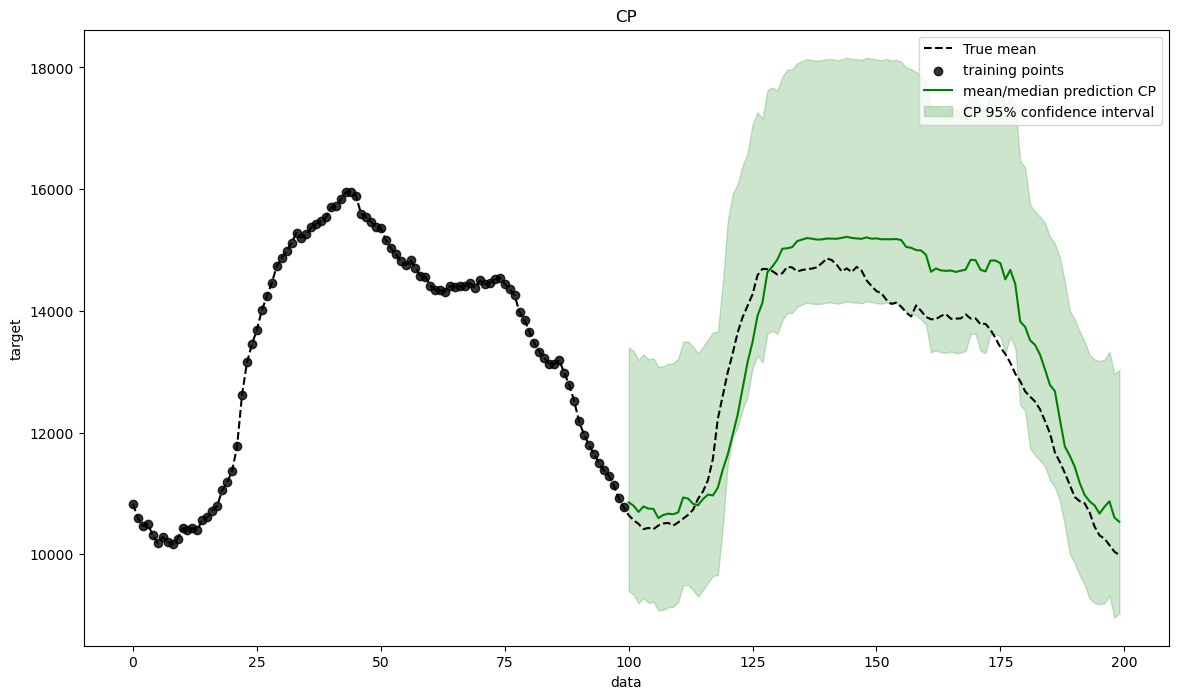

In [1]:
from compare_methods import *

native_results, posthoc_results = compare_methods(GET_DATA_FUNC, TRAIN_BASE_MODEL_FUNC, NATIVE_METHODS, POSTHOC_METHODS, METRICS, should_plot_data=True)

In [28]:
qr_results = native_results['QR']
qr_pred, qr_pis = qr_results
# dis = display

X_train, X_test, y_train, y_test, X, y = [df.to_numpy().squeeze() for df in GET_DATA_FUNC()]

In [56]:
def get_metrics(pred):
    return get_all_accuracy_metrics(pred, y_test, verbose=False)

# qr_metrics = get_all_accuracy_metrics(qr_pred, y_test)
# perfect_metrics = get_all_accuracy_metrics(y_test, y_test)

y_test_shifted = np.concatenate((y_train[-1:], y_test[:-1]))



arrs = {
    'qr': qr_pred,
    'shifted': (y_test_shifted),
    # 'perfect': get_metrics(y_test),
    'zero': (np.zeros_like(y_test)),
    'mean': (np.repeat(np.mean(y_train), y_test.size)),
}
metrics = {name: get_metrics(arr) for name, arr in arrs.items()}
for name, metric in metrics.items():
    print('\n' + name)
    display(metric)


qr


{'mae': 296.05355910300443,
 'rmse': 387.2503635093589,
 'mdae': 228.63315192340633,
 'marpd': 2.3356627820545035,
 'r2': 0.9449593523402956,
 'corr': 0.9781447696320075}


shifted


{'mae': 111.5275,
 'rmse': 151.75218491013564,
 'mdae': 84.0,
 'marpd': 0.8932616199677408,
 'r2': 0.991547799847972,
 'corr': 0.9957811691773708}


zero


{'mae': 12903.4825,
 'rmse': 13008.629604732583,
 'mdae': 13735.25,
 'marpd': 200.0,
 'r2': -61.110205151049335,
 'corr': nan}


mean


{'mae': 1432.3275,
 'rmse': 1711.2224677752306,
 'mdae': 1293.4375,
 'marpd': 11.32978353073758,
 'r2': -0.07476326712561998,
 'corr': nan}

In [59]:
import sklearn.metrics as skmet

qr_quants = {
    0.05: qr_pis[:, 0],
    0.50: qr_pred,
    0.95: qr_pis[:, 0],
}

for quant, quant_pred in qr_quants.items():
    met = skmet.mean_pinball_loss(y_test, quant_pred, alpha=quant, multioutput='raw')
    display(met)

help(skmet.mean_pinball_loss)

array([196.13405653])

array([148.02677955])

array([308.66340847])

Help on function mean_pinball_loss in module sklearn.metrics._regression:

mean_pinball_loss(y_true, y_pred, *, sample_weight=None, alpha=0.5, multioutput='uniform_average')
    Pinball loss for quantile regression.
    
    Read more in the :ref:`User Guide <pinball_loss>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    alpha : float, slope of the pinball loss, default=0.5,
        This loss is equivalent to :ref:`mean_absolute_error` when `alpha=0.5`,
        `alpha=0.95` is minimized by estimators of the 95th percentile.
    
    multioutput : {'raw_values', 'uniform_average'}  or array-like of shape             (n_outputs,), default='uniform_average'
        Defines 